# PTSD Detection using Micro expression recognision Model

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.utils
import os
import matplotlib.pyplot as plt

### Data Loading and Pre-processing

#### Data Loading

In [2]:
# Function to load micro-expression dataset
def load_microexpression_dataset(data_dir, image_size=(48, 48)):
    images = []
    labels = []

    label_mapping = {'positive': 0, 'negative': 1, 'surprise': 2}

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_name)
                image = cv2.imread(image_path)
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(label_mapping[label])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load micro-expression dataset
data_dir = "D:/Machine Learning/MFER/Dataset"
X, y = load_microexpression_dataset(data_dir)

In [3]:
# Define class labels
class_labels = ['Positive', 'Negative', 'Surprise']

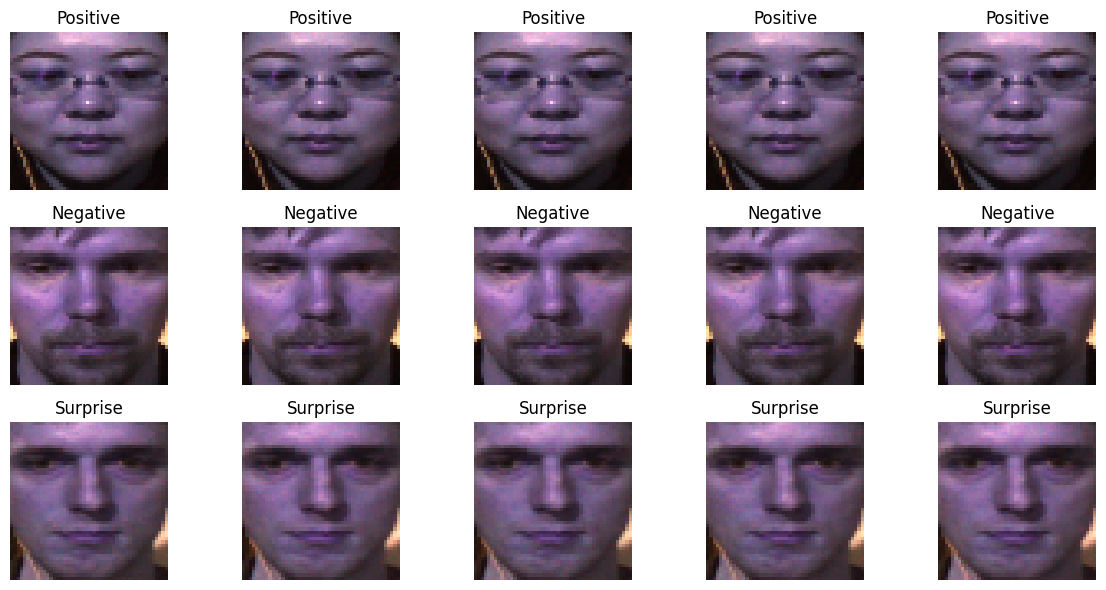

In [4]:
# Visualize sample images from each class before preprocessing
plt.figure(figsize=(12, 6))

for i, label in enumerate(class_labels):
    # Find index of first image belonging to current class
    idx = np.argmax(y == i)
    
    # Plot first 5 images of current class
    for j in range(5):
        plt.subplot(3, 5, i*5 + j + 1)
        plt.imshow(X[idx+j])
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Display size of dataset
print("Size of dataset:")
print("Number of images:", len(X))
print("Number of labels:", len(y))

# Display size of images (dimensions)
print("\nSize of images (dimensions):")
print("Image shape:", X[0].shape)

Size of dataset:
Number of images: 5514
Number of labels: 5514

Size of images (dimensions):
Image shape: (48, 48, 3)


#### Data Pre-processing

In [6]:
# Preprocessing: Normalize pixel values to [0, 1] and resize images
def preprocess_images(images, labels, image_size=(48, 48)):
    # Normalize pixel values to [0, 1]
    images = images / 255.0
    
    # Resize images
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, image_size)
        resized_images.append(resized_image)
    resized_images = np.array(resized_images)
    
    return resized_images, labels

#### Data splitting (80-20)

In [7]:
# Split the preprocessed data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess training and validation images
X_train, y_train = preprocess_images(X_train, y_train)
X_valid, y_valid = preprocess_images(X_valid, y_valid)

# Display size of training and validation sets after preprocessing
print("Size of training set after preprocessing:")
print("Number of images:", len(X_train))
print("Number of labels:", len(y_train))

print("\nSize of validation set after preprocessing:")
print("Number of images:", len(X_valid))
print("Number of labels:", len(y_valid))

print("\nSize of images (dimensions):")
print("Image shape X_train:", X_train[0].shape)
print("Image shape X_valid:", X_valid[0].shape)

Size of training set after preprocessing:
Number of images: 4411
Number of labels: 4411

Size of validation set after preprocessing:
Number of images: 1103
Number of labels: 1103

Size of images (dimensions):
Image shape X_train: (48, 48, 3)
Image shape X_valid: (48, 48, 3)


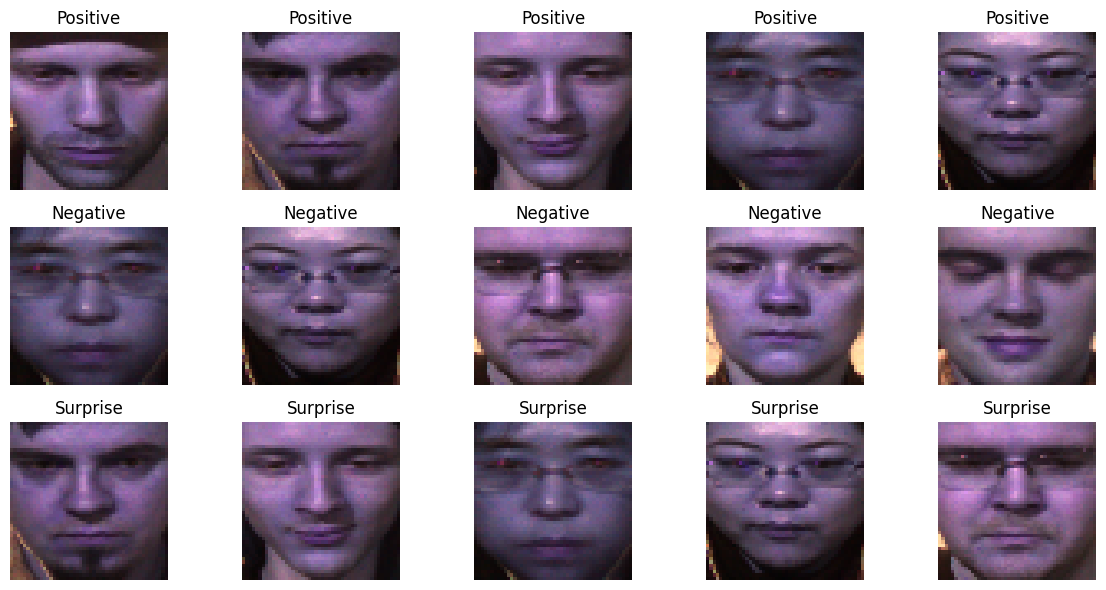

In [8]:
# Define class labels
class_labels = ['Positive', 'Negative', 'Surprise']

# Visualize sample images from each class after preprocessing
plt.figure(figsize=(12, 6))

for i, label in enumerate(class_labels):
    # Find index of first image belonging to current class
    idx = np.argmax(y_train == i)
    
    # Plot first 5 images of current class
    for j in range(5):
        plt.subplot(3, 5, i*5 + j + 1)
        plt.imshow(X_train[idx+j])
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()

### Defining Model Architecture

In [9]:
# Define the neural network model
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

In [10]:
# Build the model
input_shape = X_train[0].shape
num_classes = len(np.unique(y_train))
model = build_model(input_shape, num_classes)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 20,025,923 (76.39 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.000001, verbose=1)
callbacks = [early_stopping, lr_scheduler]

In [14]:
# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)
train_datagen.fit(X_train)

### Model Training

In [15]:
# Define batch size and steps per epoch
batch_size = 32
steps_per_epoch = len(X_train) // batch_size

# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), 
                    validation_data=(X_valid, y_valid), 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=100, 
                    callbacks=callbacks)

Epoch 1/100


c:\python 3.11\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 54s 381ms/step - accuracy: 0.4303 - loss: 1.1309 - val_accuracy: 0.5657 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 2/100
  1/137 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - accuracy: 0.5938 - loss: 0.9500

c:\python 3.11\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5938 - loss: 0.4785 - val_accuracy: 0.5621 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 53s 386ms/step - accuracy: 0.5160 - loss: 0.9780 - val_accuracy: 0.5784 - val_loss: 0.9451 - learning_rate: 0.0010
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.5000 - loss: 0.4795 - val_accuracy: 0.5739 - val_loss: 0.9472 - learning_rate: 0.0010
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 53s 388ms/step - accuracy: 0.5588 - loss: 0.9414 - val_accuracy: 0.5857 - val_loss: 0.9169 - learning_rate: 0.0010
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.6875 - loss: 0.4262 - val_accuracy: 0.5857 - val_loss: 0.9174 - learning_rate: 0.0010
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 53s 383ms/step - accuracy: 0.5677 - loss: 0.9276 - val_accuracy: 0.5793 - val_loss: 0.8989 - learning_rate: 0.0010
Epoch 8/100
  1/137 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step - accuracy: 0.7500 - lo

In [17]:
# Save the trained model
model.save("micro_expression_model.keras")

### Evaluation

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_valid, y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.6270 - loss: 0.8287
Validation Loss: 0.8438301682472229
Validation Accuracy: 0.6282864809036255


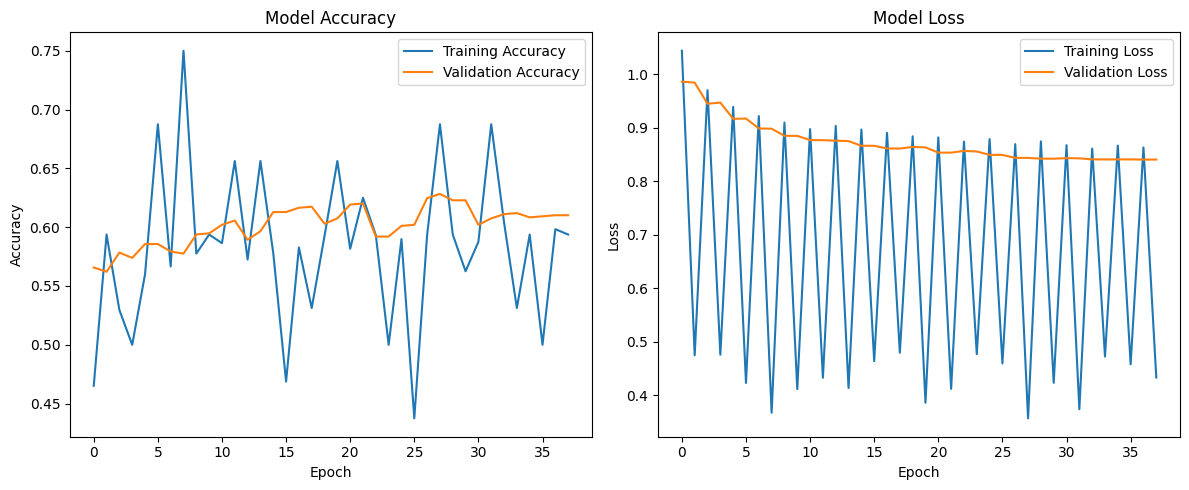

In [19]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Generate predictions
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to original labels
y_valid_classes = y_valid

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_valid_classes, y_pred_classes))

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       419
           1       0.61      0.82      0.70       468
           2       0.65      0.15      0.25       216

    accuracy                           0.63      1103
   macro avg       0.64      0.54      0.53      1103
weighted avg       0.63      0.63      0.59      1103



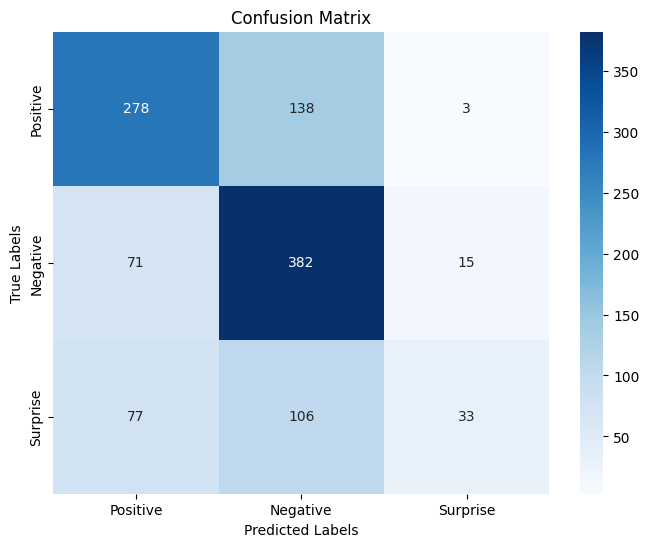

In [24]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_valid_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()